faccio un modello lo addestro poi lo copio varie volte e poi faccio un pruning interno copy.deepcopy(model)

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import copy
from torch.nn.parameter import Parameter
from Spectral_Layer_test import Spectral
from pruning_functions import BaseModel, evaluate, fit, LinearForPruning, multi_prune
from tqdm import trange

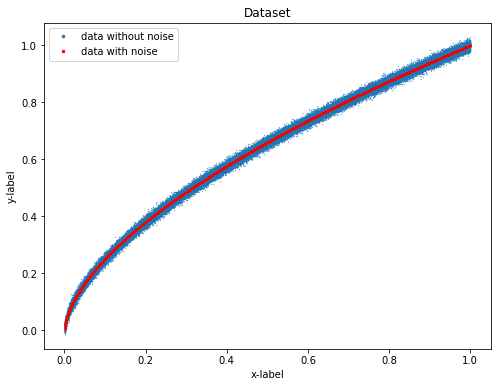

In [2]:
alpha = 0.6 
sigma = 0.01
size = 70000

x = np.linspace(0, 1, size)
z = np.random.normal(0, sigma, size)  # noise
t = x**alpha
y = t + z   # add noise

X = []
Y = []
for i in range(size):
    X.append([x[i]])
    Y.append([y[i]])
    
X = np.array(X)
Y = np.array(Y)

plt.figure (figsize = (8, 6))
plt.plot(X, Y, marker='.', linestyle = '', label='data without noise', markersize=0.5)
plt.plot(x, t, marker='.', linestyle='', color='red', label='data with noise', markersize=0.5)
plt.title('Dataset')
plt.legend(markerscale=10.)
plt.xlabel('x-label')
plt.ylabel('y-label')
plt.show()

In [3]:
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split

X = torch.from_numpy(X)
Y = torch.from_numpy(Y)

# Define dataset
dataset = TensorDataset(X, Y)
train_ds, val_ds, test_ds = random_split(dataset, [50000, 10000, 10000])

# Define data loader
batch_size = 1500
train_dl = DataLoader(train_ds, batch_size, shuffle=True)
val_dl = DataLoader(val_ds, batch_size)
test_dl = DataLoader(test_ds, batch_size)

In [4]:
# Regression model for spectral pruning
config = {'base_grad' : False,
         'start_grad' : True,
         'end_grad' : True,
         'bias': False}

class PruningRegressionSpectral(BaseModel):
    def __init__(self):
        super().__init__()
        self.spectralin = Spectral(1, 200, **config)
        self.spectral1 = Spectral(200, 200, **config)
        self.spectralout = Spectral(200, 1, **config)
    
    def forward(self,x):
        out = self.spectralin(x)  # Imput: first linear transformation
        out = self.spectral1(out) # Linear transformation
        out = F.elu(out)   # Non linear filter
        out = self.spectralout(out)  # Last linear transformation: output
        return out
   
        
pruning_model_spectral = PruningRegressionSpectral()

In [5]:
# Regression model for classical pruning
config = {'bias': False}

class PruningRegressionClassical(BaseModel):
    def __init__(self):
        super().__init__()
        self.classicalin = LinearForPruning(1, 200, **config)
        self.classical1 = LinearForPruning(200, 200, **config)
        self.classicalout = LinearForPruning(200, 1, **config)
    
    def forward(self,x):
        out = self.classicalin(x)  # Imput: first linear transformation
        out = self.classical1(out) # Linear transformation
        out = F.elu(out)   # Non linear filter
        out = self.classicalout(out)  # Last linear transformation: output
        return out
    
    
    def pruning_classical(self,
                    perc: float,
                    grad: bool = False):
        
        self.classicalin.prune(perc, grad)
        self.classical1.prune(perc, grad)
        self.classicalout.prune(perc, grad)
        
   
        
pruning_model_classical = PruningRegressionClassical()

In [6]:
# Pre train of spectral principal model 
args = {'lr': 0.01,
       'model': pruning_model_spectral,
       'train_loader': train_dl,
       'val_loader': val_dl,
       'opt_func': torch.optim.Adam}

history_principal_spectral, result_principal_spectral = fit(20, **args)

# Pre train of classical principal model 
args = {'lr': 0.01,
       'model': pruning_model_classical,
       'train_loader': train_dl,
       'val_loader': val_dl,
       'opt_func': torch.optim.Adam}

history_principal_classical, result_principal_classical = fit(20, **args)

Epoch 19: 100%|████████████████| 20/20 [00:16<00:00,  1.23epochs/s, loss=0.0104]


Epoch [19], val_loss: 0.010678, val_MAE: 0.092170, val_RMSE: 0.103329


Epoch 19: 100%|██████████████| 20/20 [00:15<00:00,  1.30epochs/s, loss=0.000341]

Epoch [19], val_loss: 0.000320, val_MAE: 0.013174, val_RMSE: 0.0178842


In [7]:
def prune(layer: Spectral, 
          in_dim: int, 
          out_dim: int,
          start_grad: bool = True, 
          end_grad: bool = True, 
          base_grad: bool = True,
          bias_grad: bool = True):
    """
    Take as imput a Spectral laye and apply pruning procedure on the eigenvalues
    
    Parameters
    ----------
    layer:
        Spectral layer only supported
    in_dim:
        new in dimension, must be int
    out_dim:
        new out dimension, must be int
    start_grad:
        If set to True layer.diag_start is trainable
    end_grad:
        If set to True layer.diag_end is trainable
    base_grad:
        if set to True layer.base is trainable
    bias_grad:
        if set to True layer.bia is trainable
        
    
    """
    
    if not isinstance(layer, Spectral):
        raise RuntimeError("Only Spectral layer is supported")
        
    diag_start = layer.diag_start.detach()
    diag_end = layer.diag_end.detach()
    base = layer.base.detach()
    if layer.bias is not None:
        bias = layer.bias.detach()
    else:
        bias = None
    abs_diag_start = torch.abs(diag_start)
    abs_diag_end = torch.abs(diag_end)
    
    # Find indeces of maximum eigenvalues
    _ , index_start = torch.topk(abs_diag_start, in_dim, dim=0)
    _ , index_end = torch.topk(abs_diag_end, out_dim, dim=1)
    
    # Prune eigenvalues and eigenvectors 
    diag_start = diag_start[index_start, 0]
    diag_end = diag_end[0, index_end]
    base = base[index_start, index_end]
    if layer.bias is not None:
        bias = bias[index_end]

    
    # New structure
    layer.diag_start = nn.Parameter(diag_start, requires_grad=start_grad)
    layer.diag_end = nn.Parameter(diag_end, requires_grad=end_grad)
    layer.base = nn.Parameter(base, requires_grad=base_grad)
    if layer.bias is not None:
        layer.bias = nn.Parameter(bias, requires_grad=bias_grad)
        
    # New shape of the model 
    layer.in_dim = index_start.size(dim=0)
    layer.out_dim = index_end.size(dim=1)
        
        
def multi_prune(model: nn.Module, 
                new_dims: int,
                start_grad: bool = True, 
                end_grad: bool = True, 
                base_grad: bool = True,
                bias_grad: bool = False):
    
    """
    Apply the pruning procedure over all the network 
    
    Parameters
    ----------
    model:
        nn.Module on witch apply pruning procedure
    new_dims:
        List of new dims, expected nex_dims = [[in1, out1],[in2, out2]...]
   start_grad:
        If set to True layer.diag_start is trainable
    end_grad:
        If set to True layer.diag_end is trainable
    base_grad:
        if set to True layer.base is trainable
    bias_grad:
        if set to True layer.bia is trainable
    
    
    Example
    -------
    
    model = nn.Sequential(Spectral(10, 200), Spectral(200, 200), nn.ELU(), Spectral(200, 1))
    new_dim = [[10,20],[20,20],[20,1]]
    multi_prune(model, new_dim)
    
    """
    
    args = {'start_grad': start_grad, 'end_grad': end_grad, 'base_grad': base_grad, 'bias_grad': bias_grad}
    layers = [module for module in model.modules() if isinstance(module, Spectral)]
    
    length = len(layers)
    length_input = len(new_dims)

    
    if not length==length_input:
        raise RuntimeError("new_dims shape is not correct")
    
    for l in range(length):
        prune(layers[l], in_dim=new_dims[l][0], out_dim=new_dims[l][1], **args)

In [21]:
cuts = [x for x in range(101) if x%5==0] # All multiples of 5 from 0 to 5
#cuts = [50, 75]


model_s = []
model_c = []

args_s = {'start_grad': True,
        'end_grad': True,
        'base_grad': True}

args_c = {'grad': True}

for i in range(len(cuts)):
    model_s.append(copy.deepcopy(pruning_model_spectral))
    model_c.append(copy.deepcopy(pruning_model_classical))
for i in range(len(cuts)):
    n = 200-(10*i)
    new_dim = [[1,n],[n,n],[n,1]]
    multi_prune(model_s[i], new_dim, **args_s)
    model_c[i].pruning_classical(perc=cuts[i], **args_c)
    

In [22]:
history_s = []
result_s = []
for i in range(len(cuts)):
    args_s = {'lr': 0.01,
              'model': model_s[i],
              'train_loader': train_dl,
              'val_loader': val_dl,
              'opt_func': torch.optim.Adam}
    print('Model: model_s',i)
    h, r = fit(20, **args_s)
    history_s.append(h)
    result_s.append(r)

Model: model_s 0


Epoch 19: 100%|███████████████| 20/20 [00:16<00:00,  1.23epochs/s, loss=0.00123]


Epoch [19], val_loss: 0.001282, val_MAE: 0.029355, val_RMSE: 0.0357995
Model: model_s 1


Epoch 19: 100%|███████████████| 20/20 [00:15<00:00,  1.25epochs/s, loss=0.00136]


Epoch [19], val_loss: 0.001248, val_MAE: 0.028799, val_RMSE: 0.0353277
Model: model_s 2


Epoch 19: 100%|███████████████| 20/20 [00:14<00:00,  1.35epochs/s, loss=0.00125]


Epoch [19], val_loss: 0.001251, val_MAE: 0.028717, val_RMSE: 0.035368
Model: model_s 3


Epoch 19: 100%|███████████████| 20/20 [00:14<00:00,  1.37epochs/s, loss=0.00125]


Epoch [19], val_loss: 0.001267, val_MAE: 0.029371, val_RMSE: 0.0355934
Model: model_s 4


Epoch 19: 100%|███████████████| 20/20 [00:14<00:00,  1.41epochs/s, loss=0.00131]


Epoch [19], val_loss: 0.001307, val_MAE: 0.030174, val_RMSE: 0.0361473
Model: model_s 5


Epoch 19: 100%|███████████████| 20/20 [00:13<00:00,  1.48epochs/s, loss=0.00119]


Epoch [19], val_loss: 0.001230, val_MAE: 0.028634, val_RMSE: 0.0350703
Model: model_s 6


Epoch 19: 100%|███████████████| 20/20 [00:12<00:00,  1.56epochs/s, loss=0.00131]


Epoch [19], val_loss: 0.001244, val_MAE: 0.028610, val_RMSE: 0.0352732
Model: model_s 7


Epoch 19: 100%|███████████████| 20/20 [00:12<00:00,  1.61epochs/s, loss=0.00114]


Epoch [19], val_loss: 0.001220, val_MAE: 0.028036, val_RMSE: 0.0349278
Model: model_s 8


Epoch 19: 100%|███████████████| 20/20 [00:11<00:00,  1.72epochs/s, loss=0.00137]


Epoch [19], val_loss: 0.001322, val_MAE: 0.028892, val_RMSE: 0.0363484
Model: model_s 9


Epoch 19: 100%|███████████████| 20/20 [00:11<00:00,  1.76epochs/s, loss=0.00133]


Epoch [19], val_loss: 0.001302, val_MAE: 0.029135, val_RMSE: 0.0360738
Model: model_s 10


Epoch 19: 100%|███████████████| 20/20 [00:10<00:00,  1.83epochs/s, loss=0.00129]


Epoch [19], val_loss: 0.001187, val_MAE: 0.028352, val_RMSE: 0.034452
Model: model_s 11


Epoch 19: 100%|████████████████| 20/20 [00:10<00:00,  1.87epochs/s, loss=0.0013]


Epoch [19], val_loss: 0.001241, val_MAE: 0.028455, val_RMSE: 0.0352216
Model: model_s 12


Epoch 19: 100%|███████████████| 20/20 [00:10<00:00,  1.96epochs/s, loss=0.00142]


Epoch [19], val_loss: 0.001356, val_MAE: 0.028629, val_RMSE: 0.0368245
Model: model_s 13


Epoch 19: 100%|███████████████| 20/20 [00:09<00:00,  2.05epochs/s, loss=0.00112]


Epoch [19], val_loss: 0.001219, val_MAE: 0.028175, val_RMSE: 0.0349052
Model: model_s 14


Epoch 19: 100%|███████████████| 20/20 [00:09<00:00,  2.12epochs/s, loss=0.00128]


Epoch [19], val_loss: 0.001287, val_MAE: 0.029052, val_RMSE: 0.0358764
Model: model_s 15


Epoch 19: 100%|███████████████| 20/20 [00:09<00:00,  2.19epochs/s, loss=0.00124]


Epoch [19], val_loss: 0.001234, val_MAE: 0.029329, val_RMSE: 0.0351302
Model: model_s 16


Epoch 19: 100%|███████████████| 20/20 [00:08<00:00,  2.24epochs/s, loss=0.00117]


Epoch [19], val_loss: 0.001092, val_MAE: 0.026601, val_RMSE: 0.0330471
Model: model_s 17


Epoch 19: 100%|██████████████| 20/20 [00:09<00:00,  2.17epochs/s, loss=0.000997]


Epoch [19], val_loss: 0.001112, val_MAE: 0.027068, val_RMSE: 0.0333498
Model: model_s 18


Epoch 19: 100%|███████████████| 20/20 [00:08<00:00,  2.47epochs/s, loss=0.00099]


Epoch [19], val_loss: 0.001066, val_MAE: 0.026552, val_RMSE: 0.0326521
Model: model_s 19


Epoch 19: 100%|██████████████| 20/20 [00:07<00:00,  2.52epochs/s, loss=0.000986]


Epoch [19], val_loss: 0.000942, val_MAE: 0.024653, val_RMSE: 0.0306972
Model: model_s 20


Epoch 19: 100%|█████████████████| 20/20 [00:07<00:00,  2.59epochs/s, loss=0.459]

Epoch [19], val_loss: 0.453543, val_MAE: 0.624443, val_RMSE: 0.673418


In [23]:
t_c = [evaluate(model_c[i], test_dl) for i in range(len(cuts))]
t_s = [evaluate(model_s[i], test_dl) for i in range(len(cuts))]

test_c_loss = [t_c[i]['val_loss'] for i in range(len(cuts))]
test_s_loss = [t_s[i]['val_loss'] for i in range(len(cuts))]
test_c_mae = [t_c[i]['val_MAE'] for i in range(len(cuts))]
test_s_mae = [t_s[i]['val_MAE'] for i in range(len(cuts))]
test_c_rmse = [t_c[i]['val_RMSE'] for i in range(len(cuts))]
test_s_rmse = [t_s[i]['val_RMSE'] for i in range(len(cuts))]

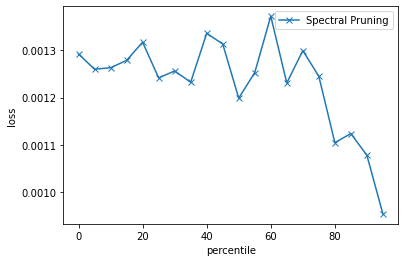

In [24]:
plt.plot(cuts[:20],test_s_loss[:20], '-x', label='Spectral Pruning')
#plt.plot(cuts,test_c_loss, '-x', label='Classical Pruning')
plt.xlabel('percentile')
plt.ylabel('loss')
plt.legend()

plt.show()

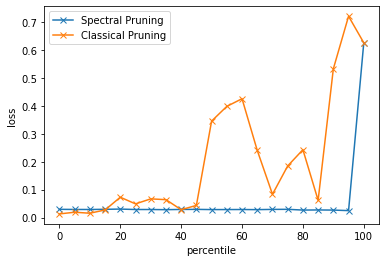

In [25]:
plt.plot(cuts,test_s_mae, '-x', label='Spectral Pruning')
plt.plot(cuts,test_c_mae, '-x', label='Classical Pruning')
plt.xlabel('percentile')
plt.ylabel('loss')
plt.legend()

plt.show()

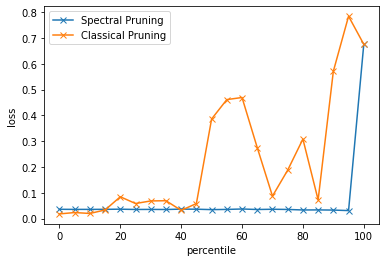

In [26]:
plt.plot(cuts,test_s_rmse, '-x', label='Spectral Pruning')
plt.plot(cuts,test_c_rmse, '-x', label='Classical Pruning')
plt.xlabel('percentile')
plt.ylabel('loss')
plt.legend()

plt.show()

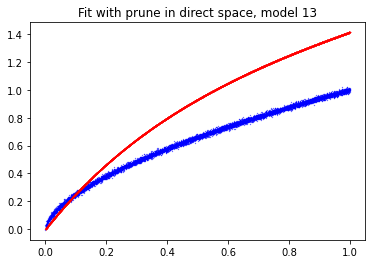

In [27]:
x_test, y_test = test_ds[:] 
y_classical = model_c[13](x_test)

plt.plot(x_test, y_test, color='blue', linestyle='', marker='.', label='data', markersize=0.5)
plt.plot(x_test, y_classical.detach(), color='red', linestyle='', marker='.', label='fit', markersize=0.5)
plt.title('Fit with prune in direct space, model 13')
plt.show()

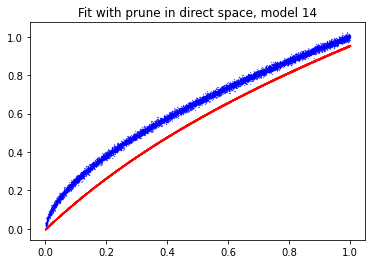

In [28]:
x_test, y_test = test_ds[:] 
y_classical = model_c[14](x_test)

plt.plot(x_test, y_test, color='blue', linestyle='', marker='.', label='data', markersize=0.5)
plt.plot(x_test, y_classical.detach(), color='red', linestyle='', marker='.', label='fit', markersize=0.5)
plt.title('Fit with prune in direct space, model 14')
plt.show()

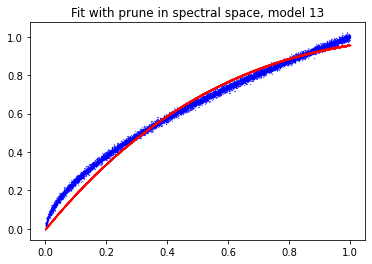

In [31]:
x_test, y_test = test_ds[:] 
y_classical = model_s[0](x_test)

plt.plot(x_test, y_test, color='blue', linestyle='', marker='.', label='data', markersize=0.5)
plt.plot(x_test, y_classical.detach(), color='red', linestyle='', marker='.', label='fit', markersize=0.5)
plt.title('Fit with prune in spectral space, model 13')
plt.show()